## Содержание
1. [Загрузка данных и подготовка их к анализу](#data_processing)
2. [Часть 1. Приоритизация гипотез](#ice_rice)
3. [Часть 2. Анализ A/B-теста](#analysis)
4. [Решение по результатам теста](#decision)

# Анализ AB-теста для интернет-магазина

Для работы мы имеем 9 гипотез по увеличению выручки интернет-магазина. Необходимо приоритизировать гипотезы, чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса, затем запустить A/B-тестирование и проанализировать результаты. 

**Описание данных**

*Данные для первой части:*

Файл /datasets/hypothesis.csv.

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

*Данные для второй части:*

Файл /datasets/orders.csv.

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv.

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

# Загрузка данных и подготовка их к анализу
<a name='data_processing'></a>

In [1]:
import pandas as pd

import scipy.stats as stats

import numpy as np

import datetime as dt

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Загрузим данные о гипотезах, заказах и пользователях в переменные hypothesis, orders и visitors соответственно:

In [2]:
hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'), # файл с гипотезами 
    pd.read_csv('/datasets/orders.csv'), # информация о заказах
    pd.read_csv('/datasets/visitors.csv'), # информация о пользователях
)

Изучим таблицы с информацией и типы данных. Для численных данных посмотрим на их статистические показатели.

Также проверим файлы на наличие дубликатов.

In [3]:
pd.options.display.max_colwidth = 150
display(hypothesis)
hypothesis.info()
display(hypothesis.describe().T)
hypothesis.duplicated().sum()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,count,mean,std,min,25%,50%,75%,max
Reach,9.0,4.777778,3.153481,1.0,3.0,3.0,8.0,10.0
Impact,9.0,4.777778,3.192874,1.0,3.0,3.0,7.0,10.0
Confidence,9.0,5.555556,3.045944,1.0,3.0,7.0,8.0,9.0
Efforts,9.0,4.888889,2.803767,1.0,3.0,5.0,6.0,10.0


0

In [4]:
display(orders.head(3))
orders.info()
display(orders.describe().T)
orders.duplicated().sum()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,count,mean,std,min,25%,50%,75%,max
transactionId,1197.0,2.155621e+09,1.229085e+09,1062393.0,1.166776e+09,2.145194e+09,3.237740e+09,4.293856e+09
visitorId,1197.0,2.165960e+09,1.236014e+09,5114589.0,1.111826e+09,2.217985e+09,3.177606e+09,4.283872e+09
revenue,1197.0,8.348006e+03,3.919113e+04,50.0,1.220000e+03,2.978000e+03,8.290000e+03,1.294500e+06


0

In [5]:
display(visitors.head(3))
visitors.info()
display(visitors.describe().T)
visitors.duplicated().sum()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,count,mean,std,min,25%,50%,75%,max
visitors,62.0,607.290323,114.40056,361.0,534.0,624.5,710.5,770.0


0

*Выявленные ошибки:*

   - некорректный формат в названиях колонок в файле hypothesis - нужно привести к нижнему регистру.
   - тип данных в колонках с датами в таблицах orders и visitors - привести к формату datetime.

Обработаем таблицу hypothesis:

In [6]:
hypothesis.columns = hypothesis.columns.str.lower()
display(hypothesis.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Обработаем таблицы orders и visitors:

In [7]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

orders.info()
print()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


**Итоги:**

Тип данных в колонках с датами в таблицах orders и visitors перевели из строки в дату.

Привели названия столбцов таблицы hypothesis к корректному виду.

Согласно статистическим показателям, нулей и отрицательных значений в данных нет. Заметно, что в таблице orders среднее и медиана сильно различаются, значит, разброс в стоимости заказов велик.

Дубликаты не найдены.

# Часть 1. Приоритизация гипотез
<a name='ice_rice'></a>

В таблице hypothesis 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами reach, impact, confidence, efforts.

**Задачи:**

- Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [8]:
display(hypothesis)

hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

display(hypothesis.loc[:,['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


**Вывод:** наиболее перспективные гипотезы по ICE под индексами: 8, 0, 7.

- Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [9]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] *  hypothesis['confidence'] / hypothesis['efforts']

display(hypothesis.loc[:,['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Вывод:** наиболее перспективные гипотезы по RICE под индексами: 7, 2, 0.

**Итоги:**

Приоритизация гипотез при применении RICE вместо ICE изменилась, т.к. при использовании RICE мы учитываем охват, что может повлиять на приоритеты гипотез. 

Так, гипотеза с индексом 7 оказалась на первом месте, потому что её параметр Reach равен 10 - наивысший бал. Гипотеза с индексом 8 заняла более низшую позицию в списке, т.к. у нее самый низкий показатель Reach - 1. Параметр Reach у гипотезы 2 выше, чем у гипотезы с индексом 0, поэтому она заняла второе место.

# Часть 2. Анализ A/B-теста
<a name='analysis'></a>

Мы провели A/B-тест и получили результаты, которые описаны в таблицах orders и visitors.

**Проанализируем A/B-тест:**

In [10]:
display(orders.head())
display(visitors.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


 **1. Построим график кумулятивной выручки по группам.**

Сначала соберем кумулятивные данные:

In [11]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulativeData.head(5))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300., 737303.]),
 <a list of 9 Text xticklabel objects>)

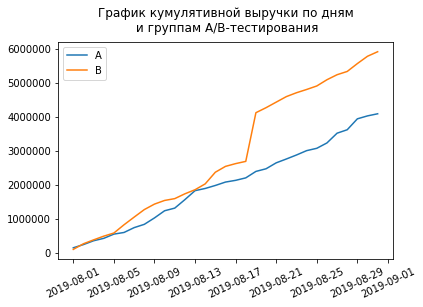

In [12]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.title('График кумулятивной выручки по дням\n и группам A/B-тестирования', pad = 10)
plt.xticks(rotation=25)

**Вывод:**

Сначала выручка почти равномерно увеличивается, а потом выручка группы B резко выросла. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

**2. Построим график кумулятивного среднего чека по группам.**

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300., 737303.]),
 <a list of 9 Text xticklabel objects>)

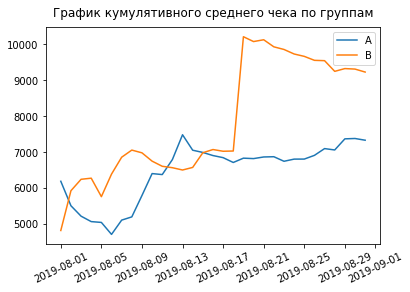

In [13]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по группам', pad = 10)
plt.xticks(rotation=25)

**Вывод:**

Результаты сильно колеблются. Возможно, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике). Затем значение среднего чека начинает приходить в норму, но еще рано говорить о стабилизации. 

**3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A.**

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300., 737303.]),
 <a list of 9 Text xticklabel objects>)

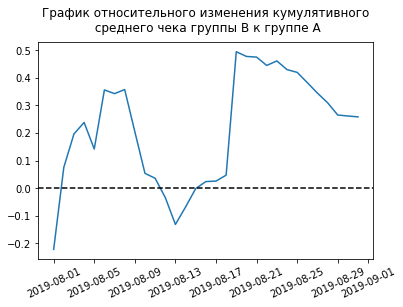

In [14]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного\n среднего чека группы B к группе A', pad = 10)
plt.xticks(rotation=25)

**Вывод:**

График различия между сегментами резко «скачет». Скорее всего, дело в крупные заказах и выбросах. На данный момент результаты группы B почти на 30% лучше.

**4. Построим график кумулятивной конверсии по группам.**

Определим минимальное и максимальное значения оси x (даты):

In [15]:
cumulativeData['date'].min(), cumulativeData['date'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-08-31 00:00:00'))

Минимальная дата - 2019-08-01

Максимальная дата - 2019-08-31

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300.]),
 <a list of 8 Text xticklabel objects>)

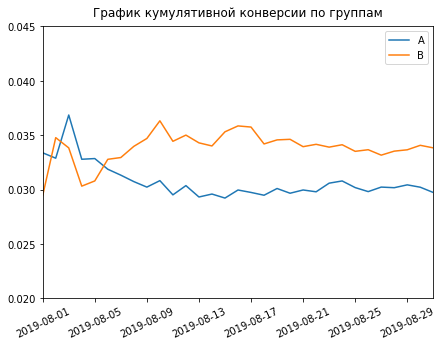

In [16]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(7,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-08-31', 0.02, 0.045])
plt.title('График кумулятивной конверсии по группам', pad = 10)
plt.xticks(rotation=25)

**Вывод:**

Конверсия группы B вырвалась вверх и зафиксировалась. Конверсия группы A тоже зафиксировалась, только ниже.

**5. Построим график относительного изменения кумулятивной конверсии группы B к группе A.**

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300.]),
 <a list of 8 Text xticklabel objects>)

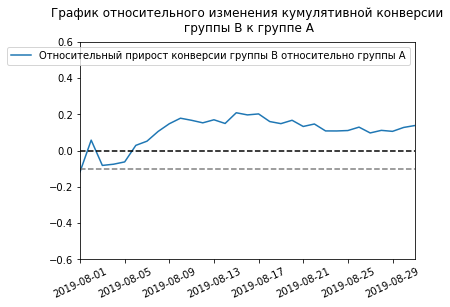

In [17]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.6, 0.6])
plt.title('График относительного изменения кумулятивной конверсии\n группы B к группе A', pad = 10)
plt.xticks(rotation=25)

**Вывод:**

Конверсия группы B лидирует относительно группы A почти с начала теста. С середины теста отличие конверсии группы B относительно конверсии группы A снижается и, возможно, уже стабилизировалось.

**6. Построим точечный график количества заказов по пользователям.**

Подсчитаем количество заказов по пользователям:

In [18]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']

display(ordersByUsers.sort_values(by='orders', ascending=False))

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
...,...,...
359,1484903144,1
360,1485964287,1
361,1494664757,1
362,1495112755,1


**Вывод:**

Есть пользователи, которые совершали 5, 8, 9, 11 заказов. Это намного больше среднестатистического числа.

Построим точечную диаграмму количества заказов на одного пользователя:

Text(0.5, 1.0, 'График количества заказов на одного пользователя')

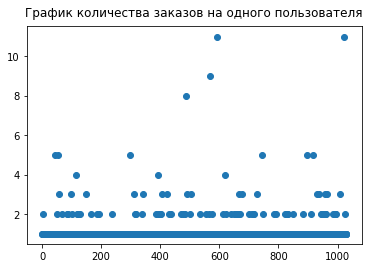

In [19]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

plt.title('График количества заказов на одного пользователя', pad = 10)

**Вывод:**

Много пользователей с 2-3 заказами. Пока не ясно, считать ли их аномалиями. Пользователей, заказавших более 3-х раз, совсем мало. Скорее всего, это аномалии.

**7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.**

In [20]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

**Вывод:**

Не более 5% пользователей совершали больше двух заказов. И не более 1% пользователей — больше четырёх заказов. За *верхнюю границу числа заказов* выберем 2 заказа на одного пользователя, и отсеем аномальных пользователей по ней.

**8. Построим точечный график стоимостей заказов.**

Text(0.5, 1.0, 'График стоимостей заказов на одного пользователя')

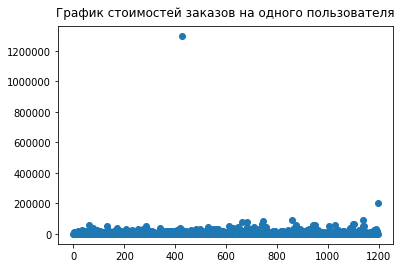

In [21]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('График стоимостей заказов на одного пользователя', pad = 10)

Масштабируем график для большей наглядности:

(0, 110000)

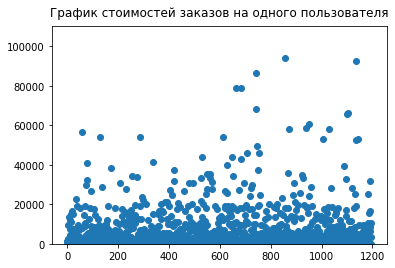

In [22]:
plt.scatter(x_values, orders['revenue'])
plt.title('График стоимостей заказов на одного пользователя', pad = 10)
plt.ylim(0, 110000)

**Вывод:**

По графикам видно, что основная часть заказов составляет менее 100 000 рублей. Но следует определить аномалии точнее.

**9. Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.**

In [23]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**Вывод:**

Не более 1% дороже 58 233 рублей. И не более 5% заказов дороже 28 000 рублей, выберем эту сумму *границей для определения аномальных заказов*.

**10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.**

Начнём с подготовки данных:

In [24]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Посчитаем различия в конверсии:

**Сформулируем гипотезу:**

*Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.*

В данном случае нам необходимо сравнить между собой 2 выборки: группа А будет видеть прежнюю версию сайта без формы подписки, а группа B увидит обновленный вариант сайта уже с формой подписки.

После теста нужно будет проанализировать результаты выручки по группам и проверить гипотезу о равенстве π₁ и π₂:

 - равны или не равны их конверсии. 
 - равны или не равны их средние чеки.

*Нулевая гипотеза H₀:* результаты равны.

*Альтернативная гипотеза H₁:* результаты различаются.

In [25]:
# Cоздадим переменные ordersByUsersA и ordersByUsersB:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 

# Объявим переменные sampleA и sampleB:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

# Выведем p-value для сравнения конверсии между группами. Округлим p-value до 5 знаков после запятой:
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

# Вычислим и выведем относительное различие в конверсии между группами. Округлим до 3 знаков после запятой:
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.00840
0.138


**Вывод:**

P-value значительно меньше 0.05, потому нулевую гипотезу отвергаем. Анализ «сырых данных» сообщает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы B к конверсии группы A равен 13.8%.

**11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.**

In [26]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.365
0.259


**Вывод:**

Исходя из того, что P-value больше 0.05, статистически значимых отличий в среднем чеке между группами нет. Однако, относительное различие среднего чека между сегментами составляет 26% - немало. Возможно, это влияние аномалий.

**12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.**

Сначала очищаем данные от аномалий:

In [27]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head())

display(abnormalUsers.shape) #сколько всего аномальных пользователей

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitorId, dtype: int64

(74,)

**Вывод:** всего 74 аномальных пользователя.

Посчитаем статистическую значимость различия конверсии после удаления аномальных пользователей:

In [28]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.00652
0.173


**Вывод:**

P-value снова значительно меньше 0.05, потому нулевую гипотезу отвергаем. Анализ очищенных данных сообщает, что в конверсии между группами есть статистически значимые различия, как и в случае с "сырыми данными". Относительный прирост конверсии группы B к конверсии группы A равен 17.3%.

**13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.**

In [29]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.369
-0.020


**Вывод:**

P-value снова больше 0.05 - статистически значимых отличий в среднем чеке между группами нет, как и в случае с "сырыми данными". Однако, разница между сегментами сократилась с 26% до 2%. Причем средний чек группы B теперь ниже среднего чека группы A на эти 2%.

**14. Варианты решений по результатам теста: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.**

*Имеющиеся факты:*

  -	Есть статистически значимое различие по конверсии между группами по «сырым» данным и по данным после фильтрации аномалий. По очищенным данным относительный прирост конверсии группы B к конверсии группы A равен 17.3%, а по "сырым" - 13.8%;
  -	Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
  - График различия конверсии между группами сообщает, что результаты группы B лучше группы A почти на 20% на данный момент.
  - График различия среднего чека колеблется ввиду наличия аномалий - крупных заказов в группе B. Сделать из этого графика определённые выводы нельзя. Но согласно ему, результаты группы B сейчас почти на 30% лучше.

# Решение по результатам теста
<a name='decision'></a>

**По результатам теста можно остановить тест и зафиксировать победу группы B.**